In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

2024-07-26 11:01:23.877702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 11:01:23.877810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 11:01:24.024850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
file_path = '/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv'
data = pd.read_csv(file_path)

# Handle null values by filling them with empty strings
data.fillna('', inplace=True)

# Define sentiment based on Rating
def get_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

data['Sentiment'] = data['Rating'].apply(get_sentiment)

# Display the first few rows of the dataset with the new Sentiment column
print(data[['Review Text', 'Rating', 'Sentiment']].head())

                                         Review Text  Rating  Sentiment
0  Absolutely wonderful - silky and sexy and comf...       4          2
1  Love this dress!  it's sooo pretty.  i happene...       5          2
2  I had such high hopes for this dress and reall...       3          1
3  I love, love, love this jumpsuit. it's fun, fl...       5          2
4  This shirt is very flattering to all due to th...       5          2


In [3]:
# Calculate the total number of each sentiment
sentiment_counts = data['Sentiment'].value_counts()
total_negative = sentiment_counts.get(0, 0)
total_neutral = sentiment_counts.get(1, 0)
total_positive = sentiment_counts.get(2, 0)

# Print the totals
print(f"Total Negative: {total_negative}")
print(f"Total Neutral: {total_neutral}")
print(f"Total Positive: {total_positive}")

Total Negative: 2407
Total Neutral: 2871
Total Positive: 18208


Unique sentiments: [2 1 0]


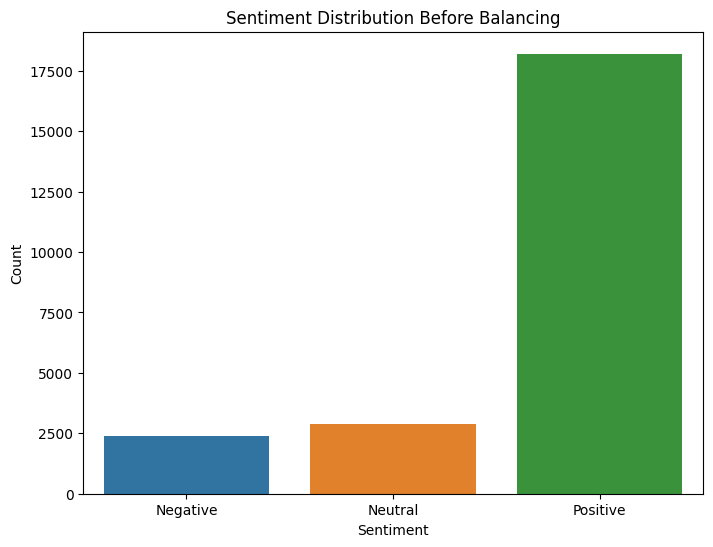

In [4]:
# Sentiment Distribution Before Balancing
print("Unique sentiments:", data['Sentiment'].unique())

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=data['Sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution Before Balancing')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

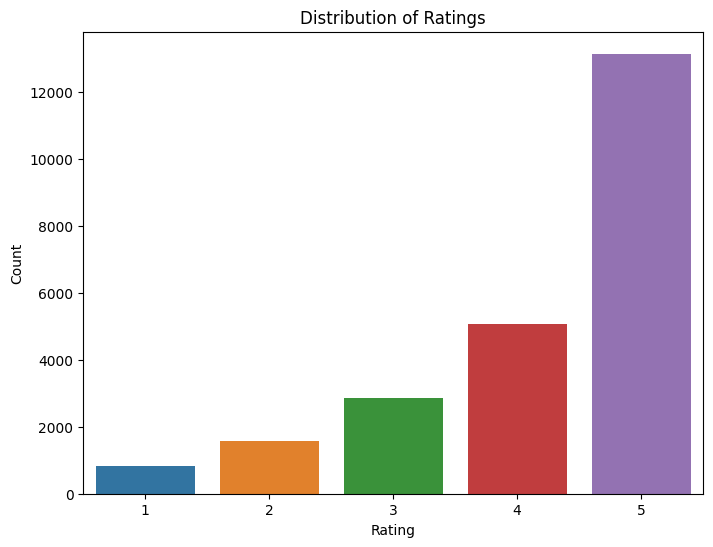

In [5]:
# Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.countplot(x=data['Rating'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

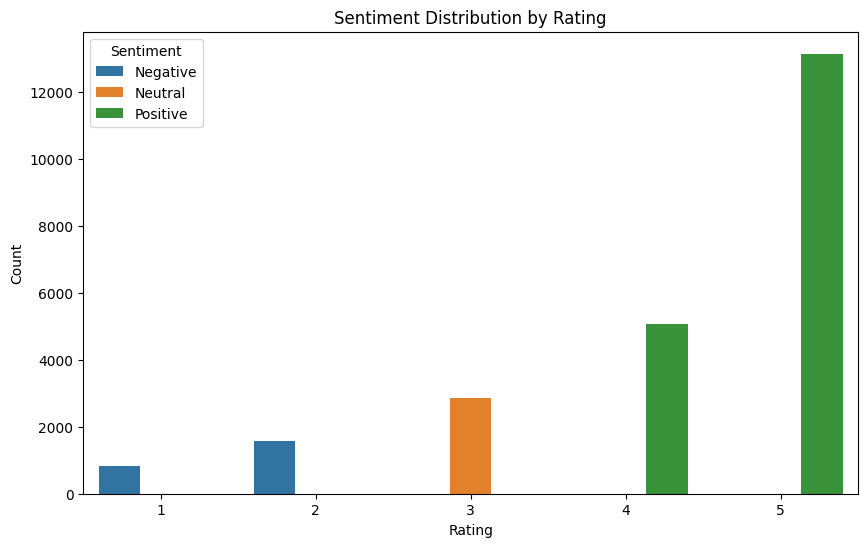

In [6]:
# Sentiment Distribution by Rating
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Sentiment', data=data)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Rating')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


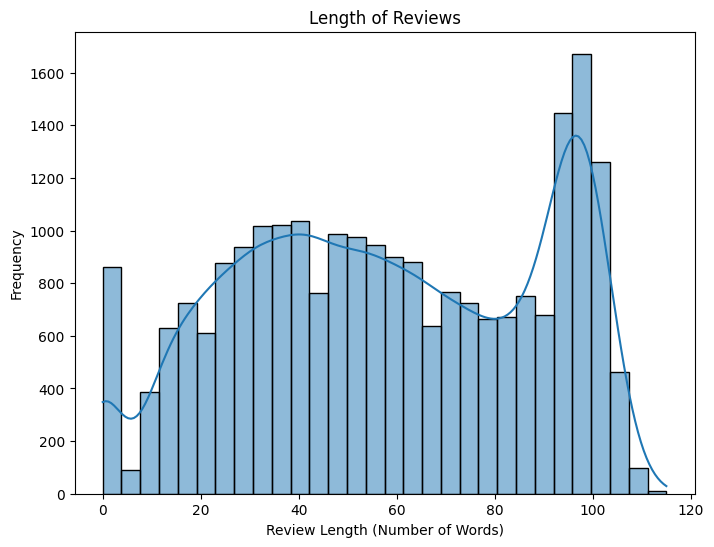

In [7]:
# Length of Reviews
data['Review Length'] = data['Review Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(data['Review Length'], bins=30, kde=True)
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Length of Reviews')
plt.show()

In [8]:
# Balance the dataset
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(data[['Review Text', 'Rating']], data['Sentiment'])

# Create a new DataFrame with the balanced data
balanced_data = pd.DataFrame({'Review Text': X_resampled['Review Text'], 'Rating': X_resampled['Rating'], 'Sentiment': y_resampled})

# Take 12,500 samples from each sentiment
balanced_data = balanced_data.groupby('Sentiment').sample(n=12500, random_state=42).reset_index(drop=True)

In [9]:
# Calculate the total number of each sentiment after balancing
balanced_sentiment_counts = balanced_data['Sentiment'].value_counts()
total_negative_balanced = balanced_sentiment_counts.get(0, 0)
total_neutral_balanced = balanced_sentiment_counts.get(1, 0)
total_positive_balanced = balanced_sentiment_counts.get(2, 0)

# Print the totals after balancing
print(f"Total Negative after balancing: {total_negative_balanced}")
print(f"Total Neutral after balancing: {total_neutral_balanced}")
print(f"Total Positive after balancing: {total_positive_balanced}")

Total Negative after balancing: 12500
Total Neutral after balancing: 12500
Total Positive after balancing: 12500


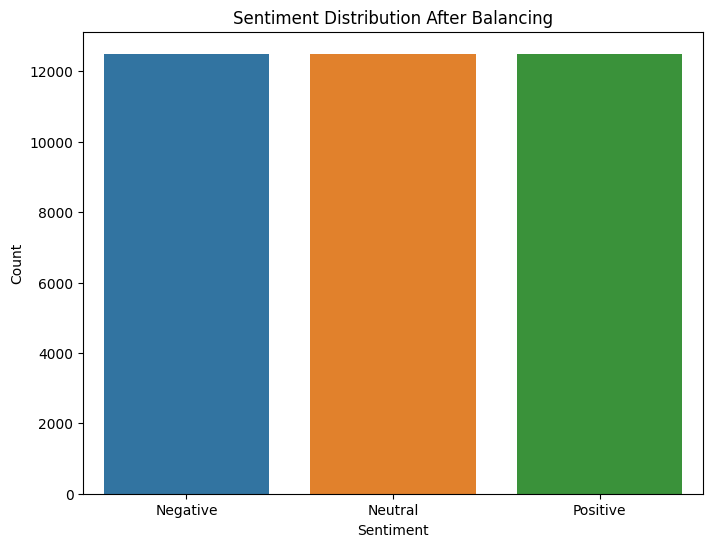

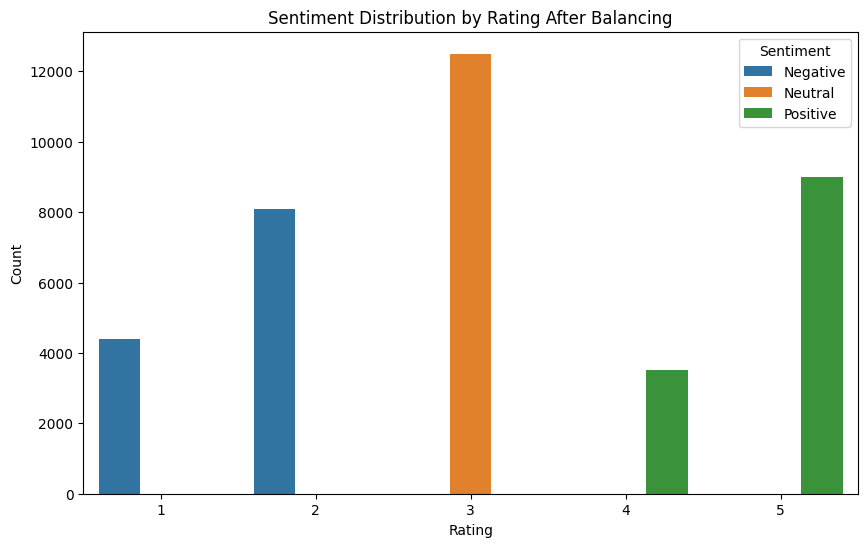

In [10]:
# Plot sentiment distribution after balancing
plt.figure(figsize=(8, 6))
sns.countplot(x=balanced_data['Sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution After Balancing')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

# Sentiment Distribution by Rating after balancing
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', hue='Sentiment', data=balanced_data)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Rating After Balancing')
plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])
plt.show()

In [13]:
# Define the target and features
target = 'Sentiment'
features = 'Review Text'

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(balanced_data[features], balanced_data[target], test_size=0.2, random_state=42)

# Tokenize the split data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
# Prepare the dataset for BERT
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
train_dataset = Dataset(train_encodings, train_labels.values)
test_dataset = Dataset(test_encodings, test_labels.values)

In [18]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',  # Output directory
    num_train_epochs=2,                    # Number of training epochs
    per_device_train_batch_size=8,         # Batch size for training
    per_device_eval_batch_size=8,          # Batch size for evaluation
    warmup_steps=500,                      # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                     # Strength of weight decay
    logging_dir='/kaggle/working/logs',    # Directory for storing logs
    logging_steps=1500,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

In [20]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Print evaluation results
print("Accuracy:", accuracy_score(test_labels, preds))
print(classification_report(test_labels, preds, target_names=['Negative', 'Neutral', 'Positive']))

Accuracy: 0.9422666666666667
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97      2513
     Neutral       0.91      0.95      0.93      2456
    Positive       0.95      0.91      0.93      2531

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500



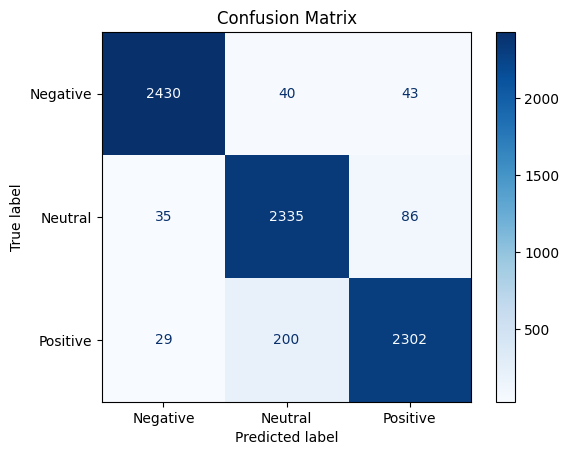

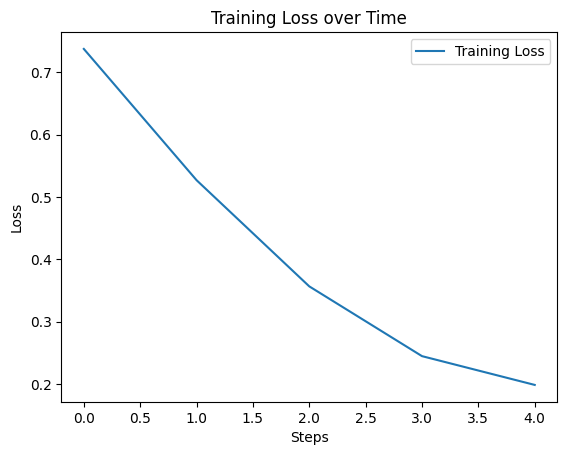

In [21]:
# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Training Graph
training_loss = trainer.state.log_history
loss_values = [entry['loss'] for entry in training_loss if 'loss' in entry]
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show()

In [22]:
# Save the trained model
model.save_pretrained('/kaggle/working/saved_model')
tokenizer.save_pretrained('/kaggle/working/saved_model')

('/kaggle/working/saved_model/tokenizer_config.json',
 '/kaggle/working/saved_model/special_tokens_map.json',
 '/kaggle/working/saved_model/vocab.txt',
 '/kaggle/working/saved_model/added_tokens.json')

In [24]:
# Load the model
model = BertForSequenceClassification.from_pretrained('/kaggle/working/saved_model')
tokenizer = BertTokenizer.from_pretrained('/kaggle/working/saved_model')

# Tokenize and encode new data
new_reviews = [
    "This dress is beautiful and fits perfectly.",
    "I did not like the fabric, it feels cheap.",
    "Some major design flaws, I could not zip it up!",
    "Great color and fit, but the fabric is a bit scratchy.",
    "The service was okay, nothing exceptional."
]

# Tokenize and encode new reviews
new_encodings = tokenizer(new_reviews, truncation=True, padding=True, return_tensors='pt')

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiments = [sentiment_labels[pred.item()] for pred in predictions]

# Print predicted sentiments for the new reviews
for review, sentiment in zip(new_reviews, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: This dress is beautiful and fits perfectly.
Predicted Sentiment: Positive

Review: I did not like the fabric, it feels cheap.
Predicted Sentiment: Negative

Review: Some major design flaws, I could not zip it up!
Predicted Sentiment: Negative

Review: Great color and fit, but the fabric is a bit scratchy.
Predicted Sentiment: Neutral

Review: The service was okay, nothing exceptional.
Predicted Sentiment: Neutral

